In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Импортируем библиотеки и модули

In [1]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Загружаем данные, делаем предобработку

In [2]:
# Загрузка данных
DATA_DIR = '/content/gdrive/MyDrive/датасеты/chest_xray/train'
CATEGORIES = ["NORMAL", "PNEUMONIA"]
IMG_SIZE = 150

data = []

def create_data(): 
    for category in CATEGORIES: # для каждой категории
        path = os.path.join(DATA_DIR, category) # находим путь к изображениям
        class_num = CATEGORIES.index(category) # задаем номер класса
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # читаем изображения в градации серого
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # меняем размер
                data.append([resized_array, class_num]) # добавляем в массив data изображение и класс
            except Exception as e:
                pass

create_data()
random.shuffle(data) # перемешиваем данные

Разделяем данные на тренировочную и тестовую выборку

In [3]:
# отделяем метки от изображений
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

# преобразуем в массив numpy

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

# разделяем на обучающую и тестовую выборку 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# приводим все значения пикселей в диапазон между 0 и 1

X_train = X_train / 255.0
X_test = X_test / 255.0


Создаем CNN модель

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                        

Определяем оптимальный размер пакетов и количество эпох с использованием Keras Callbacks для ранней остановки (EarlyStopping) и ImageDataGenerator для аугментации данных:

In [7]:
BATCH_SIZE = 32
EPOCHS = 50

# Аугментация данных
train_datagen = ImageDataGenerator(
    rotation_range=20, # поворот
    zoom_range=0.15, # масштаб
    width_shift_range=0.2, # смещение по горизонтали
    height_shift_range=0.2, # смещение по вертикали
    shear_range=0.15, # искривление
    horizontal_flip=True, # отражение по вертикали
    fill_mode="nearest") # заполнение близжайшими значениями

In [8]:
# Подготовка генератора данных
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)


In [9]:
# Callback для ранней остановки
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Обучаем модель

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/50
146/146 [==============================] - 376s 3s/step - loss: 0.4866 - accuracy: 0.8018 - val_loss: 3.3889 - val_accuracy: 0.7312
Epoch 2/50
146/146 [==============================] - 359s 2s/step - loss: 0.3267 - accuracy: 0.8690 - val_loss: 1.8829 - val_accuracy: 0.7312
Epoch 3/50
146/146 [==============================] - 336s 2s/step - loss: 0.2781 - accuracy: 0.8891 - val_loss: 1.2743 - val_accuracy: 0.7312
Epoch 4/50
146/146 [==============================] - 327s 2s/step - loss: 0.2557 - accuracy: 0.8996 - val_loss: 1.0264 - val_accuracy: 0.7312
Epoch 5/50
146/146 [==============================] - 327s 2s/step - loss: 0.2444 - accuracy: 0.9022 - val_loss: 0.8376 - val_accuracy: 0.7312
Epoch 6/50
146/146 [==============================] - 325s 2s/step - loss: 0.2414 - accuracy: 0.9035 - val_loss: 0.2254 - val_accuracy: 0.9084
Epoch 7/50
146/146 [==============================] - 326s 2s/step - loss: 0.2465 - accuracy: 0.9018 - val_loss: 0.2432 - val_accuracy: 0.9152

Строим графики accuracy и loss

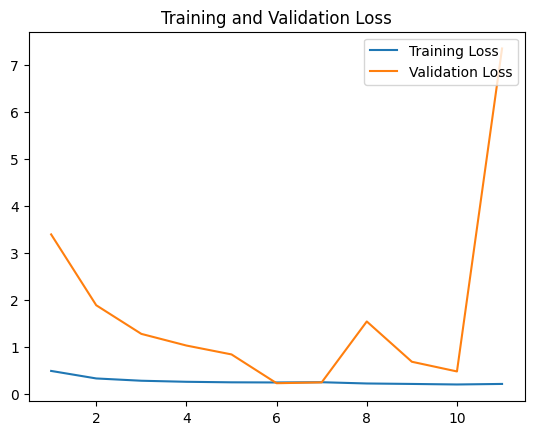

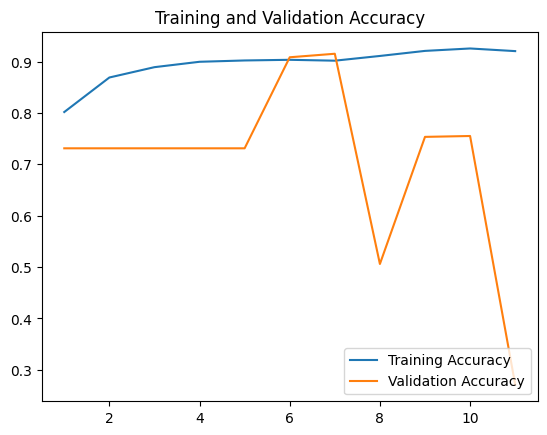

In [11]:
# График изменения loss на обучающих и проверочных данных
import matplotlib.pyplot as plt

epochs_range = range(1, len(history.history['loss']) + 1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# График изменения accuracy на обучающих и проверочных данных
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

Оцениваем обученную модель на тестовом наборе данных



In [12]:
# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

37/37 [==============================] - 18s 476ms/step - loss: 0.2254 - accuracy: 0.9084
Test loss: 0.2254
Test accuracy: 0.9084
